In [ ]:
!pip install torch_xla[tpu] -f https://storage.googleapis.com/libtpu-releases/index.html

Looking in links: https://storage.googleapis.com/libtpu-releases/index.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.2/123.2 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.6/90.6 MB 7.9 MB/s eta 0:00:00


In [ ]:
# Paso 1: Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Importar librerías necesarias
import os
import json
import torch
import torch_xla
import torch_xla.core.xla_model as xm
import torch_xla.distributed.parallel_loader as pl
import torch_xla.utils.utils as xu
import torch_xla.distributed.xla_multiprocessing as xmp
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, AutoModelForSequenceClassification
from sklearn.model_selection import train_test_split

# Paso 2: Configurar TPU
device = xm.xla_device()
print("TPU configurada en:", device)

# Paso 3: Definir ruta del archivo JSON en Google Drive
ruta_archivo = './datos_entrenar_identificar_sub_codificado_actualizado.json'

# Verificar si el archivo existe antes de leerlo
if os.path.exists(ruta_archivo):
    with open(ruta_archivo, 'r', encoding='utf-8') as archivo:
        datos_codificados_entrenamiento = json.load(archivo)
    print("Datos cargados en la variable 'datos_codificados_entrenamiento'.")
else:
    raise FileNotFoundError(f"No se encontró el archivo en {ruta_archivo}. Verifica su ubicación en Google Drive.")

# Paso 4: Preparar los datos
textos = [d["publicacion_steminizada"] for d in datos_codificados_entrenamiento]
etiquetas = [d["droga"] for d in datos_codificados_entrenamiento]

train_texts, val_texts, train_labels, val_labels = train_test_split(
    textos, etiquetas, test_size=0.2, random_state=42
)

# Paso 5: Tokenización
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=128)

# Paso 6: Crear Dataset
class DrogasDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

train_dataset = DrogasDataset(train_encodings, train_labels)
val_dataset = DrogasDataset(val_encodings, val_labels)

# Paso 7: Cargar modelo preentrenado
model = AutoModelForSequenceClassification.from_pretrained("huawei-noah/TinyBERT_General_4L_312D", num_labels=2)
model.to(device)

# Configuración de DataLoader optimizada para TPU
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)

# Configurar optimizador compatible con TPU
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)

# Función de entrenamiento optimizada para TPU
def train_epoch(model, dataloader, optimizer, device):
    model.train()
    total_loss = 0
    for step, batch in enumerate(dataloader):
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        xm.optimizer_step(optimizer)  # TPU Optimizer
        xm.mark_step()  # Forzar ejecución en TPU
        total_loss += loss.item()

        if step % 10 == 0:
            print(f"Entrenando Epoch: {step}/{len(dataloader)} ({(step/len(dataloader))*100:.2f}%) completado")

    return total_loss / len(dataloader)

# Entrenamiento del modelo en TPU
epochs = 10
for epoch in range(epochs):
    print(f"Inicio del entrenamiento para la Epoch {epoch + 1}/{epochs}")
    train_loss = train_epoch(model, train_loader, optimizer, device)
    print(f"Epoch {epoch + 1}/{epochs} | Train Loss: {train_loss:.4f}")

# Guardar modelo en Google Drive (mover a CPU antes de guardar)
model.to("cpu")
model_dir = './modelo_tinybert_drogas'
os.makedirs(model_dir, exist_ok=True)
model.save_pretrained(model_dir)
tokenizer.save_pretrained(model_dir)
print(f"Modelo guardado en {model_dir}")

Mounted at /content/drive


/usr/local/lib/python3.11/dist-packages/torch_xla/__init__.py:253: UserWarning: `tensorflow` can conflict with `torch-xla`. Prefer `tensorflow-cpu` when using PyTorch/XLA. To silence this warning, `pip uninstall -y tensorflow && pip install tensorflow-cpu`. If you are in a notebook environment such as Colab or Kaggle, restart your notebook runtime afterwards.
  warnings.warn(


TPU configurada en: xla:0
Datos cargados en la variable 'datos_codificados_entrenamiento'.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/409 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/62.7M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at huawei-noah/TinyBERT_General_4L_312D and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Inicio del entrenamiento para la Epoch 1/10
Entrenando Epoch: 0/179 (0.00%) completado
Entrenando Epoch: 10/179 (5.59%) completado
Entrenando Epoch: 20/179 (11.17%) completado
Entrenando Epoch: 30/179 (16.76%) completado
Entrenando Epoch: 40/179 (22.35%) completado
Entrenando Epoch: 50/179 (27.93%) completado
Entrenando Epoch: 60/179 (33.52%) completado
Entrenando Epoch: 70/179 (39.11%) completado
Entrenando Epoch: 80/179 (44.69%) completado
Entrenando Epoch: 90/179 (50.28%) completado
Entrenando Epoch: 100/179 (55.87%) completado
Entrenando Epoch: 110/179 (61.45%) completado
Entrenando Epoch: 120/179 (67.04%) completado
Entrenando Epoch: 130/179 (72.63%) completado
Entrenando Epoch: 140/179 (78.21%) completado
Entrenando Epoch: 150/179 (83.80%) completado
Entrenando Epoch: 160/179 (89.39%) completado
Entrenando Epoch: 170/179 (94.97%) completado
Epoch 1/10 | Train Loss: 0.5773
Inicio del entrenamiento para la Epoch 2/10
Entrenando Epoch: 0/179 (0.00%) completado
Entrenando Epoch: 10/1

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
TPU configurada en: xla:0
Datos cargados correctamente.
Iniciando evaluación del modelo con datos de validación.
Precisión en validación: 0.8978


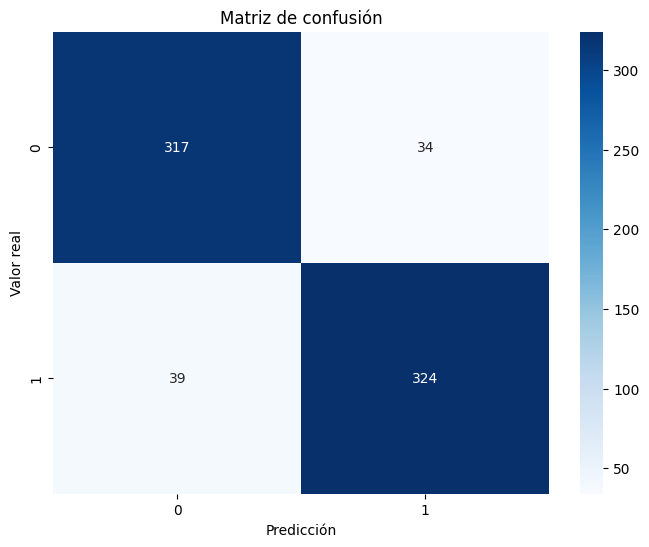

Matriz de confusión guardada en /content/drive/My Drive/Vida privada/MAESTRIA/TESIS/confusion_matrix.png.


In [ ]:
# Paso 1: Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Importar librerías necesarias
import os
import json
import torch
import torch_xla
import torch_xla.core.xla_model as xm
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, AutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Paso 2: Configurar TPU
device = xm.xla_device()
print("TPU configurada en:", device)

# Paso 3: Definir rutas en Google Drive
modelo_dir = './modelo_tinybert_drogas'
ruta_archivo = './datos_entrenar_identificar_sub_codificado_actualizado.json'
ruta_guardado_matriz = './confusion_matrix.png'

# Verificar si el archivo de datos existe antes de leerlo
if os.path.exists(ruta_archivo):
    with open(ruta_archivo, 'r', encoding='utf-8') as archivo:
        datos_codificados = json.load(archivo)
    print("Datos cargados correctamente.")
else:
    raise FileNotFoundError(f"No se encontró el archivo en {ruta_archivo}. Verifica la ubicación.")

# Paso 4: Cargar modelo y tokenizer
tokenizer = BertTokenizer.from_pretrained(modelo_dir)
model = AutoModelForSequenceClassification.from_pretrained(modelo_dir)
model.to(device)

# Paso 5: Preparar los datos (Asegurar que solo se use el conjunto de validación)
textos = [d["publicacion_steminizada"] for d in datos_codificados]
etiquetas = [d["droga"] for d in datos_codificados]

# Dividir los datos para garantizar la misma proporción que en entrenamiento (80% train, 20% test)
_, val_texts, _, val_labels = train_test_split(textos, etiquetas, test_size=0.2, random_state=42)

# Tokenizar solo los datos de validación
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=128)

class DrogasDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

# Crear dataset y dataloader solo con datos de validación
val_dataset = DrogasDataset(val_encodings, val_labels)
val_loader = DataLoader(val_dataset, batch_size=16, num_workers=2)

# Función de evaluación
def evaluate(model, dataloader, device):
    model.eval()
    predictions, true_labels = [], []
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            predictions.extend(torch.argmax(logits, dim=-1).cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    return accuracy_score(true_labels, predictions), true_labels, predictions

# Evaluación del modelo con datos de validación
print("Iniciando evaluación del modelo con datos de validación.")
accuracy, true_labels, predictions = evaluate(model, val_loader, device)
print(f"Precisión en validación: {accuracy:.4f}")

# Generar y guardar matriz de confusión
conf_matrix = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicción')
plt.ylabel('Valor real')
plt.title('Matriz de confusión')

# Guardar la matriz en Google Drive
plt.savefig(ruta_guardado_matriz)
plt.show()
print(f"Matriz de confusión guardada en {ruta_guardado_matriz}.")